## DP Prototype
## Miroslav Todorovic
## AI assisted side-channel attacks

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import wandb

2025-05-04 17:19:04.020259: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 17:19:05.094244: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 17:19:05.606377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746371946.529898   52953 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746371946.796328   52953 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746371947.800338   52953 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [33]:
from dotenv import load_dotenv
import os
import wandb

# Load the .env file
load_dotenv()

# Optionally fetch the key (for debugging or explicit control)
wandb_api_key = os.getenv("WANDB_API_KEY")

# Check if the key is available
if wandb_api_key is None:
    print("WANDB_API_KEY not found in environment variables.")
else:
    wandb.login(key=wandb_api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/miroslav/.netrc


### Method for loading the datasets.

In [14]:
def load_dataset_files(dataset_path):
    """Loads dataset files from the given path into a structured dictionary."""
    dataset = {}
    keys_file = os.path.join(dataset_path, 'keys.txt')
    plaintexts_file = os.path.join(dataset_path, 'plaintexts.txt')

    # Check if keys exist and load them
    if os.path.exists(keys_file):
        try:
            dataset['keys'] = pd.read_csv(keys_file, header=None, sep=r"\s+")
        except Exception as e:
            print(f"Error loading keys file: {e}")
    else:
        print(f"Warning: Keys file not found in {dataset_path}")

    # Load plaintexts
    if os.path.exists(plaintexts_file):
        try:
            dataset['plaintexts'] = pd.read_csv(plaintexts_file, header=None, sep=r"\s+")
        except Exception as e:
            print(f"Error loading plaintexts file: {e}")
    else:
        print(f"Warning: Plaintexts file not found in {dataset_path}")

    # Load all traces (trace_0.txt, trace_1.txt, ...)
    dataset['traces'] = {}
    for file in os.listdir(dataset_path):
        if file.startswith('trace_') and file.endswith('.txt'):
            trace_id = file.split('.')[0]
            try:
                dataset['traces'][trace_id] = pd.read_csv(os.path.join(dataset_path, file), header=None, sep=r"\s+")
            except Exception as e:
                print(f"Error loading trace file {file}: {e}")

    return dataset

In [15]:

def load_dataset_files_with_cache(dataset_path, cache_path="dataset_cache.pkl"):
    """Loads dataset files with caching to avoid reloading every time."""
    # Check if cache exists
    if os.path.exists(cache_path):
        print(f"Loading datasets from cache: {cache_path}")
        with open(cache_path, "rb") as cache_file:
            return pickle.load(cache_file)

    # If cache doesn't exist, load datasets from files
    print("Cache not found. Loading datasets from files...")
    dataset = load_dataset_files(dataset_path)

    # Save to cache
    with open(cache_path, "wb") as cache_file:
        pickle.dump(dataset, cache_file)
        print(f"Datasets cached to: {cache_path}")

    return dataset

In [16]:
def clear_cache(cache_path="dataset_cache.pkl"):
    """Clears the dataset cache."""
    if os.path.exists(cache_path):
        os.remove(cache_path)
        print(f"Cache cleared: {cache_path}")
    else:
        print(f"No cache found at: {cache_path}")

### Defining dataset paths

In [17]:
# Dataset paths
datasets = {
    "random_dataset": "datasets/random_dataset",
    "random_pt_dataset": "datasets/random_pt_dataset",
    "fixed_dataset_1": "datasets/fixed_dataset_1",
    "fixed_dataset_2": "datasets/fixed_dataset_2",
}


### Dataset Analysis
This cell involves:
- Loading the side-channel traces and corresponding labels.


In [18]:
# Load all datasets
# loaded_datasets = {name: load_dataset_files(path) for name, path in datasets.items()}


In [20]:
# Load all datasets with caching
loaded_datasets = {
    name: load_dataset_files_with_cache(path, cache_path=f"{name}_cache.pkl")
    for name, path in datasets.items()
}

Loading datasets from cache: random_dataset_cache.pkl
Loading datasets from cache: random_pt_dataset_cache.pkl
Loading datasets from cache: fixed_dataset_1_cache.pkl
Loading datasets from cache: fixed_dataset_2_cache.pkl


In [21]:
# Display dataset name, keys(if exist) and plaintext.
for dataset_name, dataset in loaded_datasets.items():
    print(f"\nDataset: {dataset_name}")

    if 'keys' in dataset:
        print("\nKeys:")
        print(dataset['keys'].head())

    if 'plaintexts' in dataset:
        print("\nPlaintexts:")
        print(dataset['plaintexts'].head())


Dataset: random_dataset

Keys:
                  0
0  65d9aad55c6c6ce7
1  d8c78292b084256d
2  22f2d1389e5fbdfd
3  03a26c615fce1a57
4  64f2b2036464e726

Plaintexts:
                  0
0  e8ed1e14087c1414
1  dc6ccd284117e9a5
2  893fe59e855cdf87
3  8c7bc727369cda98
4  c706a26018212faf

Dataset: random_pt_dataset

Plaintexts:
                  0
0  eee53883c44a3899
1  ab77e29193cad8bc
2  dc9719a897072323
3  481424feb9941d0f
4  1364cdac749fc2c6

Dataset: fixed_dataset_1

Plaintexts:
                  0
0  abcdef1234567890
1  abcdef1234567890
2  abcdef1234567890
3  abcdef1234567890
4  abcdef1234567890

Dataset: fixed_dataset_2

Plaintexts:
                  0
0  84216ba484216ba4
1  84216ba484216ba4
2  84216ba484216ba4
3  84216ba484216ba4
4  84216ba484216ba4


### Plot first trace from each dataset for analysis

In [6]:
def plot_first_trace(dataset_name):
    if 'traces' in loaded_datasets[dataset_name]:
        dataset = loaded_datasets[dataset_name]
        trace_name, trace_data = next(iter(dataset['traces'].items()))
        plt.figure(figsize=(10, 4))
        plt.plot(trace_data.iloc[:, 0], label=f"{trace_name} Sample 0")
        plt.title(f"Visualization of {trace_name} from {dataset_name}")
        plt.xlabel("Time Samples")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()

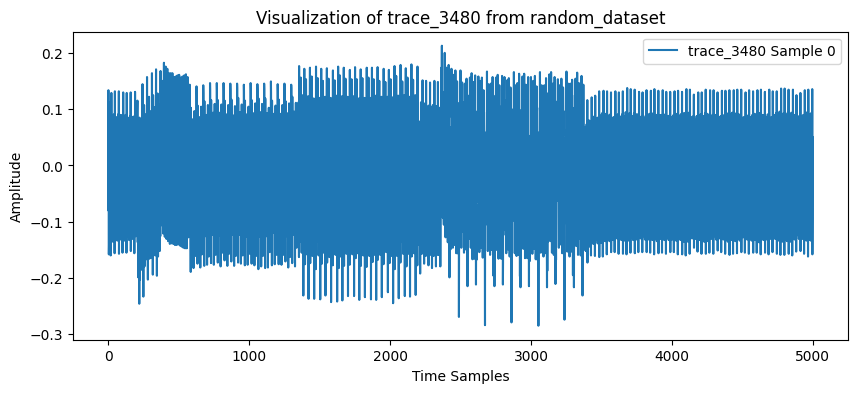

In [7]:
plot_first_trace('random_dataset')

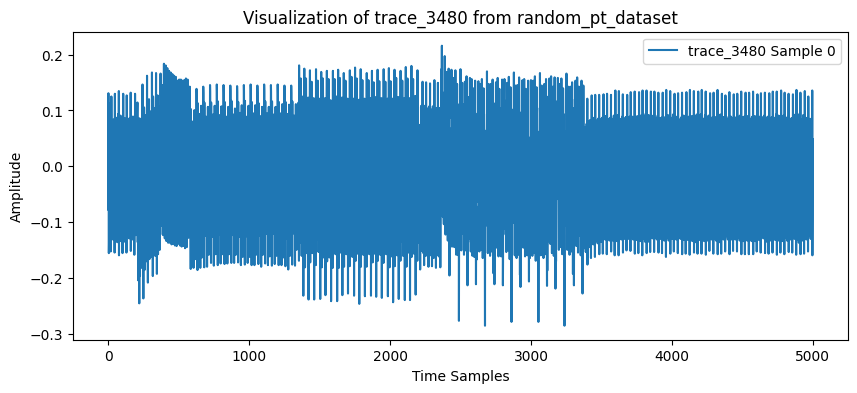

In [8]:
plot_first_trace('random_pt_dataset')

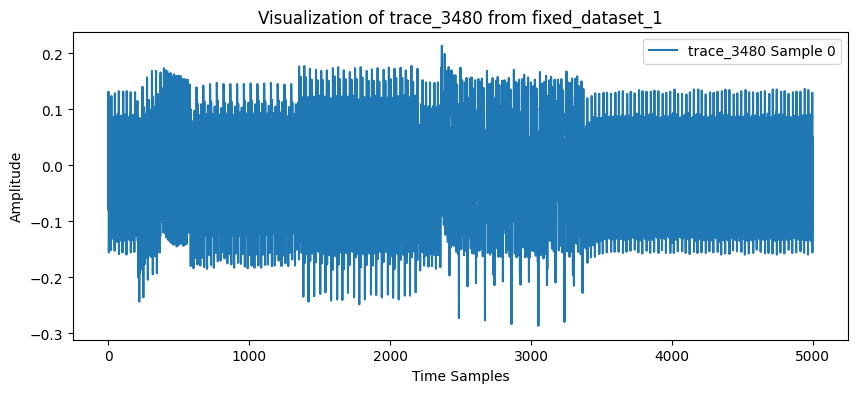

In [9]:
plot_first_trace('fixed_dataset_1')

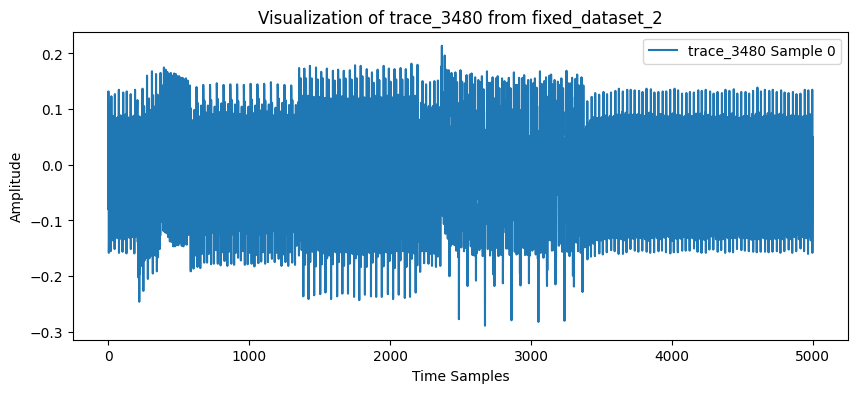

In [10]:
plot_first_trace('fixed_dataset_2')

### Trace and Plaintext Alignment:

In datasets like fixed_dataset_1 and fixed_dataset_2, the plaintexts are repeated, meaning each plaintext corresponds to multiple traces.
We'll repeat or align plaintexts to match the number of traces.

### Separation Logic:
- The random_dataset and random_pt_dataset will serve as the training set because they contain diverse keys and plaintexts.
- The fixed_dataset_1 and fixed_dataset_2 will serve as the testing set because they involve fixed keys or plaintexts.

In [2]:
def normalize_traces(traces):
    """Normalize traces to have zero mean and unit variance."""
    return (traces - traces.mean(axis=0)) / traces.std(axis=0)

In [3]:
def split_dataset(dataset, test_size=0.2, random_state=42):
    """
    Splits the dataset into training and testing sets after aligning traces and plaintexts.
    """
    if 'traces' not in dataset or 'plaintexts' not in dataset:
        raise ValueError("Dataset must contain 'traces' and 'plaintexts' for splitting.")

    # Combine all trace data into a single DataFrame
    combined_traces = pd.concat(dataset['traces'].values(), axis=0)

    # Flatten plaintexts
    plaintexts = dataset['plaintexts'][0]  # plaintexts are in the first column

    # Align traces and plaintexts
    # Normalize traces before splitting
    aligned_traces, aligned_plaintexts = align_traces_and_plaintexts(combined_traces, plaintexts)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        aligned_traces, aligned_plaintexts, test_size=test_size, random_state=random_state
    )

    return X_train, X_test, y_train, y_test


In [4]:
def align_traces_and_plaintexts(traces, plaintexts):
    """
    Align traces and plaintexts by ensuring each plaintext corresponds to the correct number of traces.
    """
    total_traces = len(traces)
    total_plaintexts = len(plaintexts)

    if total_traces % total_plaintexts != 0:
        raise ValueError(
            f"Inconsistent alignment: {total_traces} traces cannot evenly map to {total_plaintexts} plaintexts."
        )

    # Calculate mapping
    traces_per_plaintext = total_traces // total_plaintexts
    aligned_plaintexts = plaintexts.loc[plaintexts.index.repeat(traces_per_plaintext)].reset_index(drop=True)

    return traces.reset_index(drop=True), aligned_plaintexts


In [5]:
# To be used in model training.
def prepare_tf_dataset(traces, labels, batch_size=128, shuffle=True):
    """Converts traces and labels into a TensorFlow Dataset."""
    dataset = tf.data.Dataset.from_tensor_slices((traces, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(labels))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [6]:
# Testing the split method
try:
    X_train, X_test, y_train, y_test = split_dataset(loaded_datasets['random_dataset'])
    print("Training set shape:", X_train.shape)
    print("Testing set shape:", X_test.shape)
except ValueError as e:
    print(f"Error: {e}")

NameError: name 'loaded_datasets' is not defined

## CNN Architecture
### Build the CNN Model
This cell defines a function to create a convolutional neural network (CNN) with customizable hyperparameters. 
- The model includes convolutional layers, pooling layers, dense layers, and dropout layers.
- We can adjust the number of filters, kernel sizes, dropout rates, and other parameters to suit needs or tasks.

This flexibility allows experimentation with different architectures to optimize performance.

In [15]:
def build_cnn_model(input_shape=(700, 1), num_classes=256, hyperparameters=None):
    """
    Builds a CNN model based on the architecture described in the thesis document.

    Parameters:
    - input_shape: tuple, the shape of the input data (time_steps, features).
    - num_classes: int, the number of output classes.
    - hyperparameters: dict, contains model hyperparameters (e.g., filters, kernel sizes, etc.).

    Returns:
    - model: A compiled TensorFlow Keras model.
    """
    if hyperparameters is None:
        hyperparameters = {
            'conv_layers': [
                {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
                {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
            ],
            'dropout_rate': 0.5,
            'dense_units': 128,
            'learning_rate': 0.001
        }

    model = Sequential()

    # Add convolutional and pooling layers
    for i, layer in enumerate(hyperparameters['conv_layers']):
        if i == 0:
            model.add(Conv1D(filters=layer['filters'], kernel_size=layer['kernel_size'], activation='relu',
                             input_shape=input_shape))
        else:
            model.add(Conv1D(filters=layer['filters'], kernel_size=layer['kernel_size'], activation='relu'))
        model.add(MaxPooling1D(pool_size=layer['pool_size']))

    # Flatten and add dense layers
    model.add(Flatten())
    model.add(Dense(hyperparameters['dense_units'], activation='relu'))
    model.add(Dropout(hyperparameters['dropout_rate']))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

### Define Input and Output Dimensions
This cell specifies the dimensions of the input traces and the number of output classes for the CNN. 
- `input_shape`: Represents the shape of the side-channel traces, where `trace_length` is the number of time samples.
- `num_classes`: Corresponds to the number of possible output classes (e.g., 256 for 8-bit key hypotheses in AES).

These parameters must be aligned with our dataset.

In [16]:
trace_length = 700
input_shape = (trace_length, 1)  # trace_length = number of time samples  # Example input shape (time_steps, features)
# num_classes to match the task (e.g., 256 for AES key hypotheses)
num_classes = 256  # Example number of output classes


### Display Model Summary
This cell generates a summary of the CNN architecture, displaying:
- Each layer’s name, type, and output shape.
- The number of trainable and non-trainable parameters.
- The total parameter count.

This summary enables us to verify the model’s structure and ensure it matches the design goals.


In [17]:
# Build model with default hyperparameters
model = build_cnn_model(input_shape=input_shape, num_classes=num_classes)

# Summary of the model
model.summary()

/home/miroslav/Documents/FIIT/THESIS/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-03 20:27:17.812810: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 698, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 349, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 347, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 173, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11072)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,417,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,456,704 (5.56 MB)

 Trainable params: 1,456,704 (5.56 MB)

 Non-trainable params: 0 (0.00 B)

### Customize CNN Hyperparameters
This cell demonstrates how to define and modify hyperparameters for the CNN model, such as:
- Number of convolutional layers and their parameters (`filters`, `kernel_size`, `pool_size`).
- Dropout rate to prevent overfitting.
- Dense layer units and learning rate.

By changing these settings, we can adapt the model to different datasets and tasks.


In [36]:
# Example for editing hyperparameters
custom_hyperparameters = {
    'conv_layers': [
        {'filters': 16, 'kernel_size': 5, 'pool_size': 2},
        {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    ],
    'dropout_rate': 0.3,
    'dense_units': 64,
    'learning_rate': 0.0005
}

# Build model with custom hyperparameters
#custom_model = build_cnn_model(input_shape=input_shape, num_classes=num_classes, hyperparameters=custom_hyperparameters)
#custom_model.summary()

In [38]:
import random


# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="mt-thesis",
    # Set the wandb project where this run will be logged.
    project="side-channel-attacks",
    name="cnn-model-training",
    # Track hyperparameters and run metadata.
    config=custom_hyperparameters,
)

# Simulate training.
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset

    # Log metrics to wandb.
    run.log({"acc": acc, "loss": loss})

# Finish the run and upload any remaining data.
run.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


acc,▁▆▇▇████
loss,█▃▄▂▃▂▂▁
acc,0.81417
loss,0.2202
